In [2]:
from keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow as tf

In [3]:
import os

# Caminho local para a pasta raiz do projeto
root_path = "./"  

# Listar diretórios no caminho raiz
print("📁 Diretórios no caminho raiz:")
print(os.listdir(root_path))

# Verificar conteúdo de um caminho específico
specific_path = os.path.join(root_path, "garbage-noaug-70-15-15")
if os.path.exists(specific_path):
    print(f"\n📁 Conteúdo de {specific_path}:")
    print(os.listdir(specific_path))
else:
    print(f"\n❌ Caminho {specific_path} não existe")

# Função para listar diretórios com profundidade
def list_dirs(path, indent=0):
    for item in os.listdir(path):
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            print(" " * indent + "📁 " + item)
            if indent < 4:
                list_dirs(full_path, indent + 2)
        else:
            print(" " * indent + "📄 " + item)

# Explorar estrutura de diretórios
print("\n📂 Estrutura de diretórios:")
list_dirs(root_path, 0)

📁 Diretórios no caminho raiz:
['.DS_Store', 'requirements.txt', 'SSC_Model_T_TransferLearning_without_aug.ipynb', 'SSC_2_final_optimized.ipynb', 'garbage-dataset', 'SSC_3_modelo_LeakyReLU.ipynb', 'model_checkpoint.h5', 'garbage-noaug-70-15-15', 'models', 'convert_to_tf_lite.py', '.gitignore', '.venv', 'ssc.py', '.git', 'SSC_Model_T_TransferLearning.ipynb', 'SSC.ipynb', 'SSC_4.ipynb']

📁 Conteúdo de ./garbage-noaug-70-15-15:
['README.roboflow.txt', 'valid', 'README.dataset.txt', '.DS_Store', 'test', 'train']

📂 Estrutura de diretórios:
📄 .DS_Store
📄 requirements.txt
📄 SSC_Model_T_TransferLearning_without_aug.ipynb
📄 SSC_2_final_optimized.ipynb
📁 garbage-dataset
  📁 paper
    📄 paper_926.jpg
    📄 paper_2718.jpg
    📄 paper_1205.jpg
    📄 paper_1563.jpg
    📄 paper_2042.jpg
    📄 paper_2730.jpg
    📄 paper_1239.jpg
    📄 paper_1588.jpg
    📄 paper_2081.jpg
    📄 paper_701.jpg
    📄 paper_20241210_133202.jpg
    📄 paper_715.jpg
    📄 paper_3162.jpg
    📄 paper_1775.jpg
    📄 paper_2268.jp

In [4]:
# Improved Metal GPU detection for Apple Silicon
try:
    # First try looking for GPU devices (newer TF versions label Metal as GPU)
    gpus = tf.config.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f"Found {len(gpus)} GPU device(s)")
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU acceleration enabled (Metal)")
    # If no GPU found, try looking specifically for MPS devices
    elif hasattr(tf.config, 'list_physical_devices') and len(tf.config.list_physical_devices('MPS')) > 0:
        mps_devices = tf.config.list_physical_devices('MPS')
        tf.config.experimental.set_visible_devices(mps_devices[0], 'MPS')
        print("MPS (Metal) device enabled")
    else:
        print("No GPU or MPS device found, using CPU")
        
    # Verify what device is being used
    print("\nDevice being used:", tf.config.get_visible_devices())
    
    # Test with a simple operation to confirm GPU usage
    with tf.device('/GPU:0'):
        a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
        b = tf.constant([[5.0, 6.0], [7.0, 8.0]])
        c = tf.matmul(a, b)
        print("Matrix multiplication result:", c)
        print("GPU test successful!")
except Exception as e:
    print(f"Error setting up GPU: {e}")
    print("Falling back to CPU")

Found 1 GPU device(s)
Error setting up GPU: Physical devices cannot be modified after being initialized
Falling back to CPU


In [5]:
# Enable mixed precision (faster on GPU)
from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')  # Use FP16 instead of FP32

In [6]:
train_dir = specific_path + "/train"
validation_dir = specific_path + "/valid"
test_dir = specific_path + "/test"

# Images are 640, but 224 is way faster for training
IMG_SIZE = 160
BATCH_SIZE = 64


train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

train_dataset_pref = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset_pref = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset_pref = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 13833 files belonging to 10 classes.
Found 2965 files belonging to 10 classes.
Found 2964 files belonging to 10 classes.


In [7]:
# Add this code to check class balance
import pandas as pd

class_counts = {}
for _, labels in train_dataset:
    for label in labels.numpy():
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

df = pd.DataFrame({'class': train_dataset.class_names, 'count': [class_counts.get(i, 0) for i in range(len(train_dataset.class_names))]})
print(df)

        class  count
0     battery    666
1  biological    690
2   cardboard   1297
3     clothes   3730
4       glass   2093
5       metal    708
6       paper   1184
7     plastic   1382
8       shoes   1410
9       trash    673


2025-06-05 18:56:03.513286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [8]:
# Simpler CNN architecture for faster training
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

# Reduced number of filters and layers for faster training
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D()(x)

# Simplified dense layers
x = layers.Flatten()(x)
x = layers.Dropout(0.3)(x)  # Reduced dropout
x = layers.Dense(256, activation='relu')(x)  # Smaller dense layer
outputs = layers.Dense(len(train_dataset.class_names), activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

# Use a simpler optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Compile with better optimizer
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary to see the reduction in parameters
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,203,274 (50.37 MB)

 Trainable params: 13,203,274 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Add to your training cell
import time

class TimeoutCallback(tf.keras.callbacks.Callback):
    def __init__(self, max_time_mins=2):
        super().__init__()
        self.max_time_sec = max_time_mins * 60
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self.start_time
        if elapsed > self.max_time_sec:
            print(f"\nReached time limit ({self.max_time_sec/3600:.1f}h). Stopping training.")
            self.model.stop_training = True

# Maximum 20 minutes of training to prevent overheating
timeout_cb = TimeoutCallback(max_time_mins=20)


In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', 
    patience=5,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "models/model_checkpoint.keras", 
    save_best_only=True,
    monitor="val_accuracy"
)

# Add more callbacks for better training
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Calculate class weights
total = sum(class_counts.values())
class_weight = {i: total/count for i, count in class_counts.items()}


In [11]:
import psutil
import subprocess
import platform

class ResourceMonitorCallback(tf.keras.callbacks.Callback):
    def __init__(self, check_interval=1):
        super().__init__()
        self.check_interval = check_interval
        self.epoch_count = 0
        self.is_mac = platform.system() == 'Darwin'
        
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_count += 1
        if self.epoch_count % self.check_interval == 0:
            # Get basic info
            cpu_percent = psutil.cpu_percent(interval=0.5)
            memory = psutil.virtual_memory()
            mem_used = f"{memory.percent}% ({memory.used / 1024**3:.1f}GB)"
            
            # Temperature check - simplified
            temp = "N/A"
            if self.is_mac:
                try:
                    # Try thermal level from pmset (no sudo needed)
                    result = subprocess.run(['pmset', '-g', 'therm'], capture_output=True, text=True)
                    if "CPU_Thermal_level" in result.stdout:
                        temp = result.stdout.strip()
                except: pass
            
            # Simplified output
            print(f"\n[Epoch {epoch}] CPU: {cpu_percent}% | Memory: {mem_used}")
            print(f"Thermal: {temp}")
            print(f"GPU: {'Active' if self.is_mac else 'Unknown'}")

# Create monitor that checks every epoch
resource_monitor = ResourceMonitorCallback(check_interval=1)

In [12]:
# TRAINN!!!!
history = model.fit(
    train_dataset_pref,
    validation_data=validation_dataset_pref,
    epochs=1,
    class_weight=class_weight, 
    callbacks=[early_stopping, reduce_lr, checkpoint_cb, timeout_cb, resource_monitor]
)

# Save the entire model (architecture + weights + optimizer state)
model.save("models/garbage_classifier_model.keras")  
print("Model saved successfully!")

2025-06-05 18:56:03.938025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1963 - loss: 41.1925
[Epoch 0] CPU: 15.5% | Memory: 80.9% (5.6GB)
Thermal: N/A
GPU: Active
217/217 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.1968 - loss: 41.1215 - val_accuracy: 0.5022 - val_loss: 1.5100 - learning_rate: 0.0010
Model saved successfully!


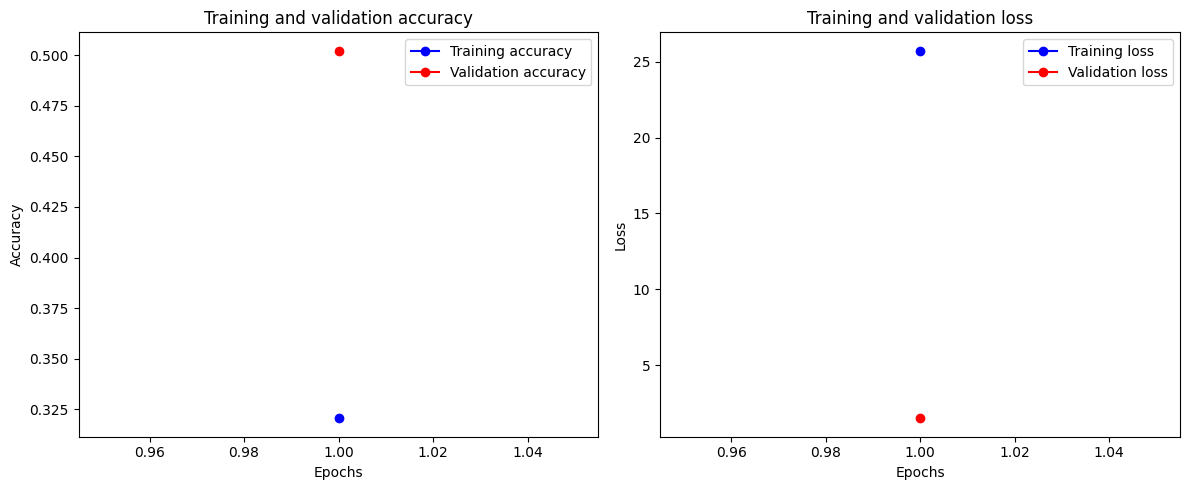

In [13]:
# Corrected plotting code for newer TensorFlow versions
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5012 - loss: 1.5269
Test accuracy: 0.4946
Test loss: 1.5112
Classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


2025-06-05 18:56:33.983692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


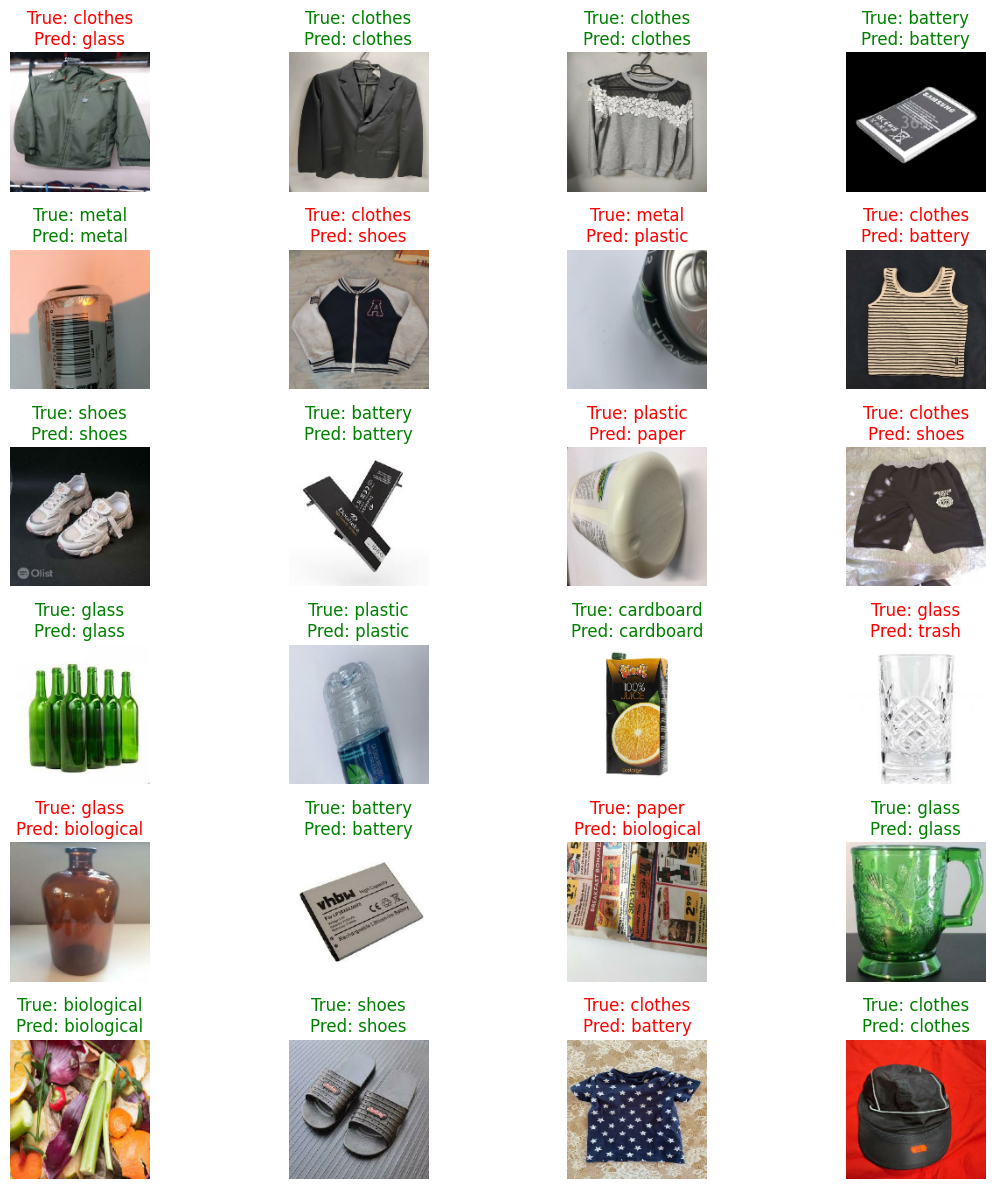

: 

In [ ]:
# Evaluate on test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

# Visualize some predictions
import numpy as np

# Get class names from your dataset
class_names = train_dataset.class_names
print("Classes:", class_names)

# Function to show predictions for a batch of images
plt.figure(figsize=(12, 12))
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    
    for i in range(24):
        plt.subplot(6, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        correct = labels[i] == pred_classes[i]
        color = "green" if correct else "red"
        
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_classes[i]]}", 
                 color=color)
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Add to your notebook
import tensorflow as tf
import time
import os
import json
from datetime import datetime

print(f"[{datetime.now()}] Starting TFLite conversion process...")
print(f"[{datetime.now()}] TensorFlow version: {tf.__version__}")

# Timing function
def log_time(start_time, message):
    elapsed = time.time() - start_time
    print(f"[{datetime.now()}] {message} - Took {elapsed:.2f} seconds")
    return time.time()

total_start = time.time()
step_start = total_start

print(f"[{datetime.now()}] Step 1: Loading saved Keras model...")
try:
    model = tf.keras.models.load_model("models/garbage_classifier_model.keras")
    step_start = log_time(step_start, "✅ Model loaded successfully")
    print(f"[{datetime.now()}] Model summary:")
    model.summary()
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error loading model: {str(e)}")
    raise

print(f"[{datetime.now()}] Step 2: Getting class names...")
try:
    class_names = train_dataset.class_names
    print(f"[{datetime.now()}] ✅ Found {len(class_names)} classes: {class_names}")
    step_start = log_time(step_start, "Class names retrieved")
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error getting class names: {str(e)}")
    raise

print(f"[{datetime.now()}] Step 3: Setting up TFLite converter...")
try:
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimize for size and latency
    print(f"[{datetime.now()}] ✅ Converter configured with optimizations")
    step_start = log_time(step_start, "Converter setup complete")
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error setting up converter: {str(e)}")
    raise

print(f"[{datetime.now()}] Step 4: Converting model to TFLite format (this might take a while)...")
try:
    conversion_start = time.time()
    tflite_model = converter.convert()
    print(f"[{datetime.now()}] ✅ Conversion successful! TFLite model size: {len(tflite_model) / (1024 * 1024):.2f} MB")
    step_start = log_time(conversion_start, "Model conversion")
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error during conversion: {str(e)}")
    raise

print(f"[{datetime.now()}] Step 5: Saving TFLite model to file...")
try:
    with open('garbage_classifier.tflite', 'wb') as f:
        f.write(tflite_model)
    file_size = os.path.getsize('garbage_classifier.tflite') / (1024 * 1024)
    print(f"[{datetime.now()}] ✅ TFLite model saved successfully, file size: {file_size:.2f} MB")
    step_start = log_time(step_start, "TFLite model file save")
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error saving TFLite model: {str(e)}")
    raise

print(f"[{datetime.now()}] Step 6: Saving class names to JSON...")
try:
    with open('class_names.json', 'w') as f:
        json.dump(class_names, f)
    print(f"[{datetime.now()}] ✅ Class names JSON saved")
    step_start = log_time(step_start, "Class names save")
except Exception as e:
    print(f"[{datetime.now()}] ❌ Error saving class names: {str(e)}")
    raise

log_time(total_start, "🎉 Complete TFLite conversion process")
print(f"[{datetime.now()}] Model and class names ready for mobile app deployment")

[2025-06-05 18:56:34.290732] Starting TFLite conversion process...
[2025-06-05 18:56:34.290867] TensorFlow version: 2.16.2
[2025-06-05 18:56:34.290952] Step 1: Loading saved Keras model...
[2025-06-05 18:56:34.642319] ✅ Model loaded successfully - Took 0.35 seconds
[2025-06-05 18:56:34.642393] Model summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,609,828 (151.10 MB)

 Trainable params: 13,203,274 (50.37 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,406,554 (100.73 MB)

[2025-06-05 18:56:34.649154] Step 2: Getting class names...
[2025-06-05 18:56:34.649219] ✅ Found 10 classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
[2025-06-05 18:56:34.649227] Class names retrieved - Took 0.01 seconds
[2025-06-05 18:56:34.649246] Step 3: Setting up TFLite converter...
[2025-06-05 18:56:34.649363] ✅ Converter configured with optimizations
[2025-06-05 18:56:34.649368] Converter setup complete - Took 0.00 seconds
[2025-06-05 18:56:34.649385] Step 4: Converting model to TFLite format (this might take a while)...
INFO:tensorflow:Assets written to: /var/folders/b_/drnx8m_j31g75ml803q8l1yr0000gn/T/tmp8p_w5_hm/assets


INFO:tensorflow:Assets written to: /var/folders/b_/drnx8m_j31g75ml803q8l1yr0000gn/T/tmp8p_w5_hm/assets
